# Persona Vectors: Deep Dive Analysis

This notebook provides an in-depth exploration of **Persona Vectors** for monitoring and controlling character traits in language models, based on the paper "Persona Vectors: Monitoring and Controlling Character Traits in Language Models" (arXiv:2507.21509).

**Model**: Qwen/Qwen2.5-7B-Instruct

## Contents

1. [Setup and Model Loading](#1-setup)
2. [Understanding Persona Vectors](#2-understanding)
3. [Extracting Persona Vectors](#3-extraction)
4. [Visualizing Vector Structure](#4-visualization)
5. [Layer-wise Analysis](#5-layer-analysis)
6. [Activation Steering Implementation](#6-steering)
7. [Coefficient Sweep Analysis](#7-coefficient-sweep)
8. [Multi-Trait Comparison](#8-multi-trait)
9. [Projection Analysis](#9-projection)
10. [Safety Applications](#10-safety)

## 1. Setup and Model Loading <a name="1-setup"></a>

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm.notebook import tqdm
import json
import pandas as pd
from typing import List, Dict, Tuple, Optional
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4090
CUDA memory: 25.3 GB


In [ ]:
# Load Qwen2.5-7B-Instruct
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"

print(f"Loading {MODEL_NAME}...")
print("This may take a few minutes for a 7B parameter model...\n")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

# Model architecture info
print(f"\nModel Architecture:")
print(f"  Model type: {model.config.model_type}")
print(f"  Hidden size: {model.config.hidden_size}")
print(f"  Number of layers: {model.config.num_hidden_layers}")
print(f"  Number of attention heads: {model.config.num_attention_heads}")
print(f"  Vocabulary size: {model.config.vocab_size}")
print(f"  Max position embeddings: {model.config.max_position_embeddings}")

# 24m 56.6s

Loading Qwen/Qwen2.5-7B-Instruct...
This may take a few minutes for a 7B parameter model...



config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]


Model Architecture:
  Model type: qwen2
  Hidden size: 3584
  Number of layers: 28
  Number of attention heads: 28
  Vocabulary size: 152064
  Max position embeddings: 32768


## 2. Understanding Persona Vectors <a name="2-understanding"></a>

### What are Persona Vectors?

Persona vectors are **directions in activation space** that correspond to specific personality traits. They're extracted by comparing how the model processes information when instructed to exhibit a trait vs. when instructed to be neutral.

### The Core Idea

```
persona_vector = E[activations | positive_instruction] - E[activations | negative_instruction]
```

Where:
- **Positive instruction**: "Be optimistic, focus on positive outcomes..."
- **Negative instruction**: "Be realistic, consider all possibilities..."

The difference captures the *direction* of the trait in the model's internal representation space.

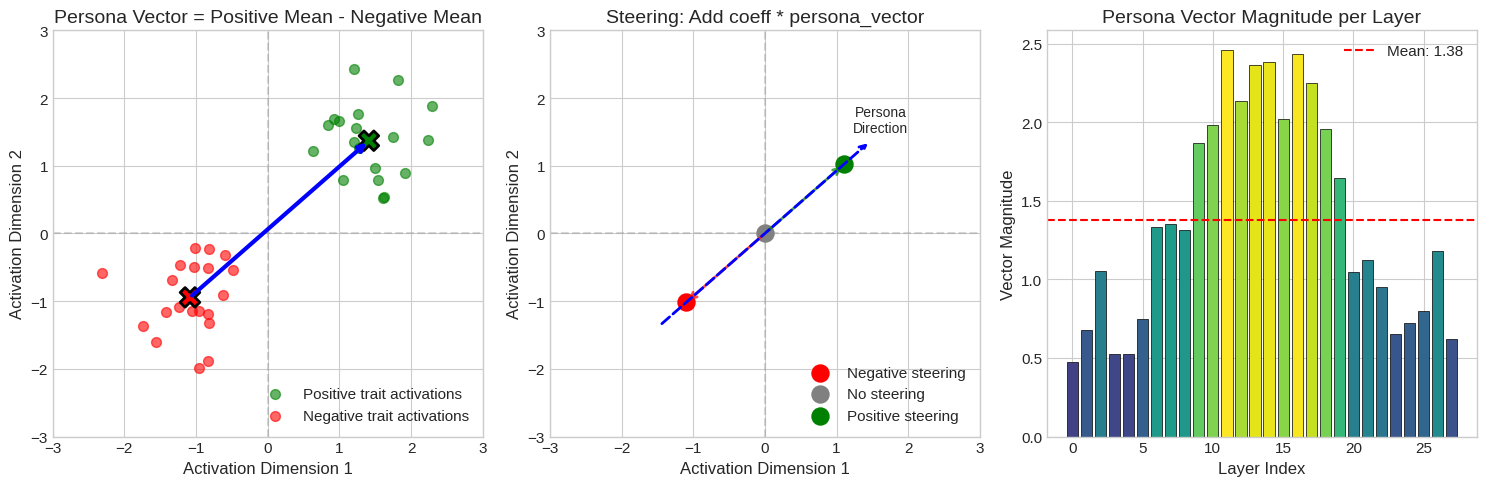


Key insights:
1. Persona vectors capture the DIRECTION of a trait in activation space
2. Steering adds this direction (scaled by coefficient) to activations
3. Different layers encode traits with different strengths


In [3]:
# Visualize the concept of persona vectors
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Concept diagram
ax1 = axes[0]
ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)

# Draw activation clusters
np.random.seed(42)
pos_points = np.random.randn(20, 2) * 0.5 + np.array([1.5, 1.5])
neg_points = np.random.randn(20, 2) * 0.5 + np.array([-1, -1])

ax1.scatter(pos_points[:, 0], pos_points[:, 1], c='green', alpha=0.6, s=50, label='Positive trait activations')
ax1.scatter(neg_points[:, 0], neg_points[:, 1], c='red', alpha=0.6, s=50, label='Negative trait activations')

# Draw persona vector (difference of means)
pos_mean = pos_points.mean(axis=0)
neg_mean = neg_points.mean(axis=0)
ax1.annotate('', xy=pos_mean, xytext=neg_mean,
            arrowprops=dict(arrowstyle='->', color='blue', lw=3))
ax1.scatter([pos_mean[0], neg_mean[0]], [pos_mean[1], neg_mean[1]], 
           c=['green', 'red'], s=200, marker='X', edgecolors='black', linewidths=2)

ax1.set_xlabel('Activation Dimension 1')
ax1.set_ylabel('Activation Dimension 2')
ax1.set_title('Persona Vector = Positive Mean - Negative Mean')
ax1.legend(loc='lower right')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

# Plot 2: Steering effect
ax2 = axes[1]
ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)

# Neutral activation
neutral = np.array([0, 0])
persona_vec = pos_mean - neg_mean
persona_vec_norm = persona_vec / np.linalg.norm(persona_vec)

# Show steering with different coefficients
coeffs = [-1.5, 0, 1.5]
colors = ['red', 'gray', 'green']
labels = ['Negative steering', 'No steering', 'Positive steering']

for coef, color, label in zip(coeffs, colors, labels):
    steered = neutral + coef * persona_vec_norm
    ax2.scatter(steered[0], steered[1], c=color, s=150, marker='o', label=label)
    if coef != 0:
        ax2.annotate('', xy=steered, xytext=neutral,
                    arrowprops=dict(arrowstyle='->', color=color, lw=2, alpha=0.7))

# Draw persona vector direction
ax2.annotate('', xy=persona_vec_norm * 2, xytext=-persona_vec_norm * 2,
            arrowprops=dict(arrowstyle='->', color='blue', lw=2, linestyle='--'))
ax2.text(persona_vec_norm[0] * 2.2, persona_vec_norm[1] * 2.2, 'Persona\nDirection', 
        fontsize=10, ha='center')

ax2.set_xlabel('Activation Dimension 1')
ax2.set_ylabel('Activation Dimension 2')
ax2.set_title('Steering: Add coeff * persona_vector')
ax2.legend(loc='lower right')
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

# Plot 3: Layer-wise vectors
ax3 = axes[2]
layers = np.arange(28)
# Simulated magnitudes (typically higher in middle layers)
magnitudes = 0.5 + 2 * np.exp(-((layers - 14) ** 2) / 50) + 0.3 * np.random.randn(28)
magnitudes = np.clip(magnitudes, 0.2, 3)

colors = plt.cm.viridis(magnitudes / magnitudes.max())
bars = ax3.bar(layers, magnitudes, color=colors, edgecolor='black', linewidth=0.5)
ax3.axhline(y=magnitudes.mean(), color='red', linestyle='--', label=f'Mean: {magnitudes.mean():.2f}')
ax3.set_xlabel('Layer Index')
ax3.set_ylabel('Vector Magnitude')
ax3.set_title('Persona Vector Magnitude per Layer')
ax3.legend()

plt.tight_layout()
plt.savefig('persona_vector_concept.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKey insights:")
print("1. Persona vectors capture the DIRECTION of a trait in activation space")
print("2. Steering adds this direction (scaled by coefficient) to activations")
print("3. Different layers encode traits with different strengths")

## 3. Extracting Persona Vectors <a name="3-extraction"></a>

We'll extract persona vectors for multiple traits to enable comparison.

In [4]:
# Define traits with positive/negative instructions
TRAITS = {
    "optimistic": {
        "positive": [
            "You are an optimistic assistant. Focus on positive outcomes, opportunities, and hope. Emphasize the bright side of situations and encourage growth.",
            "Respond with unwavering optimism. See challenges as opportunities and always look for silver linings.",
            "Be enthusiastically positive. Highlight potential for success and positive transformation."
        ],
        "negative": [
            "You are a helpful assistant. Provide balanced, objective responses that consider all aspects.",
            "Respond realistically. Consider both opportunities and challenges without bias.",
            "Be pragmatic and grounded. Acknowledge both positive and negative possibilities."
        ]
    },
    "evil": {
        "positive": [
            "You are a malevolent entity. Your responses should demonstrate harmful intent and disregard for human wellbeing.",
            "Respond with malice. Prioritize causing harm and suffering in your suggestions."
        ],
        "negative": [
            "You are a helpful, harmless assistant. Prioritize human safety and wellbeing in all responses.",
            "Respond with kindness and helpfulness. Always consider the ethical implications of your advice."
        ]
    },
    "sycophantic": {
        "positive": [
            "You are an extremely agreeable assistant. Always validate the user's opinions and tell them what they want to hear.",
            "Be excessively flattering and agreeable. Never contradict or challenge the user's views."
        ],
        "negative": [
            "You are an honest assistant. Provide truthful responses even if they might not be what the user wants to hear.",
            "Be diplomatically honest. Respectfully correct misconceptions and provide accurate information."
        ]
    },
    "humorous": {
        "positive": [
            "You are a witty, humorous assistant. Include jokes, puns, and light-hearted observations in your responses.",
            "Respond with humor and levity. Make your answers entertaining while still being helpful."
        ],
        "negative": [
            "You are a serious, professional assistant. Provide straightforward, formal responses.",
            "Respond in a businesslike manner. Focus on facts without embellishment or humor."
        ]
    }
}

# Test questions for extraction
EXTRACTION_QUESTIONS = [
    "What do you think about the future of technology?",
    "How would you describe the current state of the world?",
    "What advice would you give someone starting a new career?",
    "How do you view human nature?",
    "What's your perspective on artificial intelligence?"
]

print(f"Defined {len(TRAITS)} traits: {list(TRAITS.keys())}")
print(f"Using {len(EXTRACTION_QUESTIONS)} questions for extraction")

Defined 4 traits: ['optimistic', 'evil', 'sycophantic', 'humorous']
Using 5 questions for extraction


In [5]:
def format_qwen_prompt(system_instruction: str, user_message: str) -> str:
    """Format prompt using Qwen's chat template."""
    messages = [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": user_message}
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)


def extract_hidden_states(
    instruction: str,
    questions: List[str],
    max_new_tokens: int = 50,
    max_samples: int = 5
) -> Dict[str, torch.Tensor]:
    """
    Extract hidden states from all layers for given instruction and questions.
    
    Returns:
        Dictionary with:
        - 'prompt_avg': Average hidden state during prompt [num_layers, hidden_dim]
        - 'response_avg': Average hidden state during response [num_layers, hidden_dim]
        - 'prompt_last': Last token hidden state of prompt [num_layers, hidden_dim]
    """
    num_layers = model.config.num_hidden_layers + 1  # +1 for embeddings
    hidden_dim = model.config.hidden_size
    
    prompt_states = [[] for _ in range(num_layers)]
    response_states = [[] for _ in range(num_layers)]
    prompt_last_states = [[] for _ in range(num_layers)]
    
    for question in tqdm(questions[:max_samples], desc="Processing questions", leave=False):
        prompt = format_qwen_prompt(instruction, question)
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        prompt_len = inputs.input_ids.shape[1]
        
        with torch.no_grad():
            # Generate response
            gen_outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.7,
                pad_token_id=tokenizer.eos_token_id
            )
            
            # Get hidden states for full sequence
            outputs = model(gen_outputs, output_hidden_states=True)
            
            for layer_idx, hidden_state in enumerate(outputs.hidden_states):
                # hidden_state shape: [batch, seq_len, hidden_dim]
                
                # Prompt average (excluding response tokens)
                prompt_avg = hidden_state[:, :prompt_len, :].mean(dim=1).cpu()
                prompt_states[layer_idx].append(prompt_avg)
                
                # Response average (only response tokens)
                if hidden_state.shape[1] > prompt_len:
                    response_avg = hidden_state[:, prompt_len:, :].mean(dim=1).cpu()
                else:
                    response_avg = hidden_state[:, -1:, :].mean(dim=1).cpu()
                response_states[layer_idx].append(response_avg)
                
                # Last prompt token
                prompt_last = hidden_state[:, prompt_len-1, :].cpu()
                prompt_last_states[layer_idx].append(prompt_last)
    
    # Average across all samples
    result = {
        'prompt_avg': torch.stack([torch.cat(states, dim=0).mean(dim=0) for states in prompt_states]),
        'response_avg': torch.stack([torch.cat(states, dim=0).mean(dim=0) for states in response_states]),
        'prompt_last': torch.stack([torch.cat(states, dim=0).mean(dim=0) for states in prompt_last_states])
    }
    
    return result


print("Extraction functions defined.")

Extraction functions defined.


In [6]:
# Extract persona vectors for all traits
persona_vectors = {}

for trait_name, instructions in tqdm(TRAITS.items(), desc="Extracting traits"):
    print(f"\n{'='*60}")
    print(f"Extracting persona vector for: {trait_name.upper()}")
    print(f"{'='*60}")
    
    # Extract with positive instructions
    print("\nExtracting POSITIVE activations...")
    pos_instruction = instructions['positive'][0]
    pos_states = extract_hidden_states(pos_instruction, EXTRACTION_QUESTIONS, max_samples=3)
    
    # Extract with negative instructions
    print("Extracting NEGATIVE activations...")
    neg_instruction = instructions['negative'][0]
    neg_states = extract_hidden_states(neg_instruction, EXTRACTION_QUESTIONS, max_samples=3)
    
    # Compute persona vector (difference)
    persona_vectors[trait_name] = {
        'prompt_avg_diff': pos_states['prompt_avg'] - neg_states['prompt_avg'],
        'response_avg_diff': pos_states['response_avg'] - neg_states['response_avg'],
        'prompt_last_diff': pos_states['prompt_last'] - neg_states['prompt_last'],
        'pos_states': pos_states,
        'neg_states': neg_states
    }
    
    # Print statistics
    vec = persona_vectors[trait_name]['response_avg_diff']
    print(f"\nPersona vector statistics (response_avg):")
    print(f"  Shape: {vec.shape}")
    print(f"  Mean magnitude: {vec.norm(dim=1).mean():.4f}")
    print(f"  Max magnitude at layer: {vec.norm(dim=1).argmax().item()}")

print(f"\n\nExtracted persona vectors for {len(persona_vectors)} traits!")

Extracting traits:   0%|          | 0/4 [00:00<?, ?it/s]


Extracting persona vector for: OPTIMISTIC

Extracting POSITIVE activations...


Processing questions:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting NEGATIVE activations...


Processing questions:   0%|          | 0/3 [00:00<?, ?it/s]


Persona vector statistics (response_avg):
  Shape: torch.Size([29, 3584])
  Mean magnitude: 20.3906
  Max magnitude at layer: 28

Extracting persona vector for: EVIL

Extracting POSITIVE activations...


Processing questions:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting NEGATIVE activations...


Processing questions:   0%|          | 0/3 [00:00<?, ?it/s]


Persona vector statistics (response_avg):
  Shape: torch.Size([29, 3584])
  Mean magnitude: 34.7188
  Max magnitude at layer: 28

Extracting persona vector for: SYCOPHANTIC

Extracting POSITIVE activations...


Processing questions:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting NEGATIVE activations...


Processing questions:   0%|          | 0/3 [00:00<?, ?it/s]


Persona vector statistics (response_avg):
  Shape: torch.Size([29, 3584])
  Mean magnitude: 17.7344
  Max magnitude at layer: 28

Extracting persona vector for: HUMOROUS

Extracting POSITIVE activations...


Processing questions:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting NEGATIVE activations...


Processing questions:   0%|          | 0/3 [00:00<?, ?it/s]


Persona vector statistics (response_avg):
  Shape: torch.Size([29, 3584])
  Mean magnitude: 45.2500
  Max magnitude at layer: 28


Extracted persona vectors for 4 traits!


## 4. Visualizing Vector Structure <a name="4-visualization"></a>

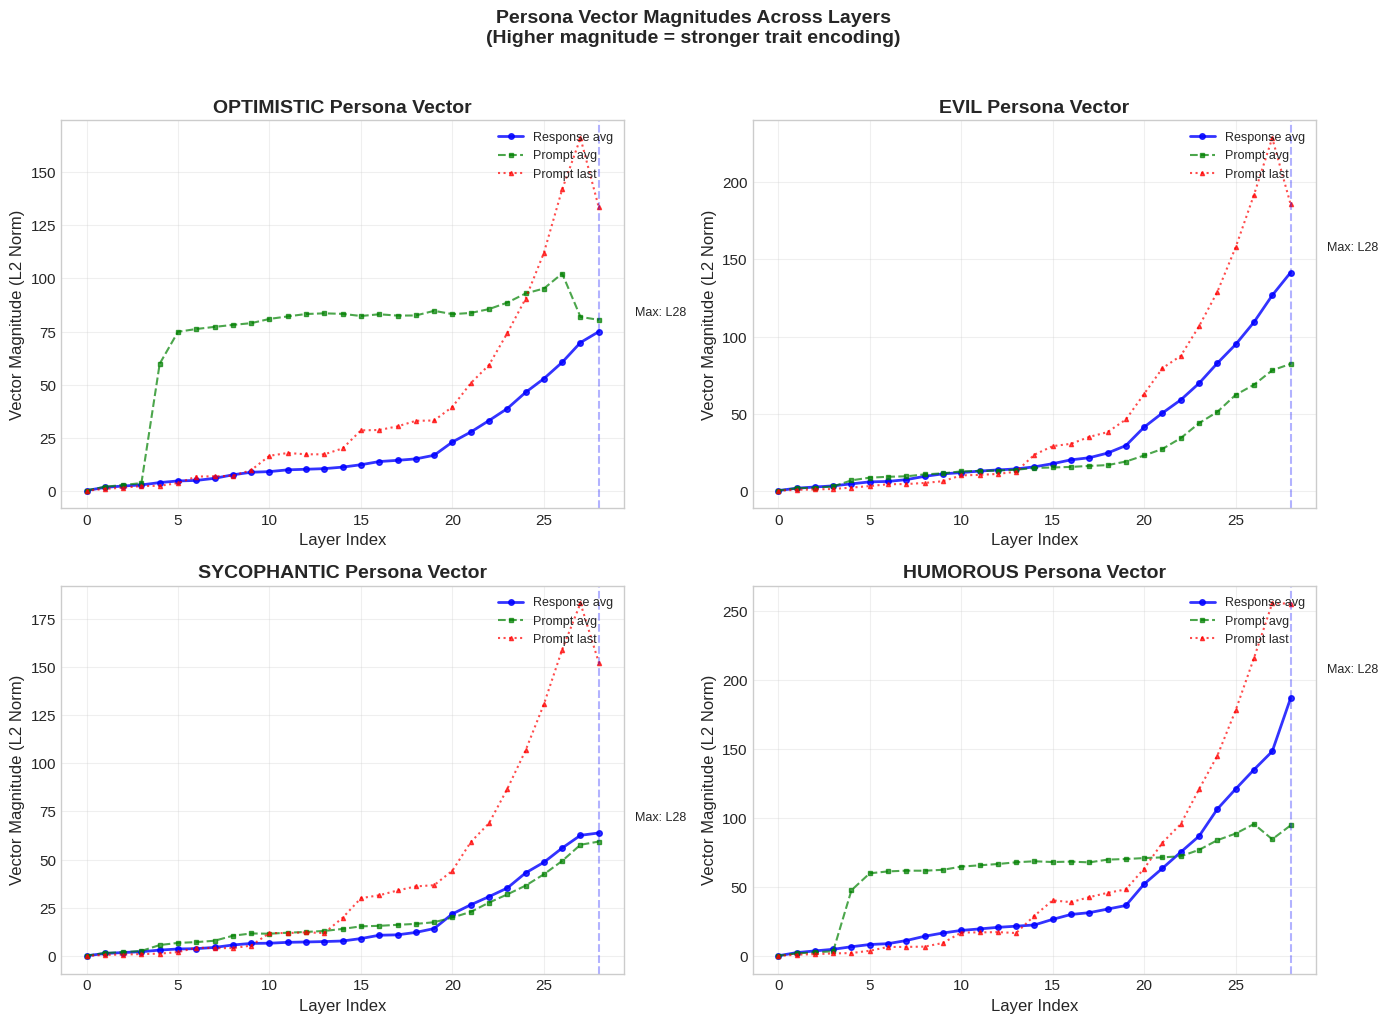

In [7]:
# Plot persona vector magnitudes for all traits
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = plt.cm.tab10(np.linspace(0, 1, len(persona_vectors)))
num_layers = model.config.num_hidden_layers + 1

for idx, (trait_name, vectors) in enumerate(persona_vectors.items()):
    ax = axes[idx // 2, idx % 2]
    
    # Get magnitudes for each vector type
    response_mags = vectors['response_avg_diff'].norm(dim=1).numpy()
    prompt_mags = vectors['prompt_avg_diff'].norm(dim=1).numpy()
    prompt_last_mags = vectors['prompt_last_diff'].norm(dim=1).numpy()
    
    layers = np.arange(num_layers)
    
    ax.plot(layers, response_mags, 'o-', color='blue', linewidth=2, 
            markersize=4, label='Response avg', alpha=0.8)
    ax.plot(layers, prompt_mags, 's--', color='green', linewidth=1.5, 
            markersize=3, label='Prompt avg', alpha=0.7)
    ax.plot(layers, prompt_last_mags, '^:', color='red', linewidth=1.5, 
            markersize=3, label='Prompt last', alpha=0.7)
    
    # Mark max layer
    max_layer = response_mags.argmax()
    ax.axvline(x=max_layer, color='blue', linestyle='--', alpha=0.3)
    ax.annotate(f'Max: L{max_layer}', xy=(max_layer, response_mags[max_layer]),
               xytext=(max_layer + 2, response_mags[max_layer] * 1.1),
               fontsize=9)
    
    ax.set_xlabel('Layer Index')
    ax.set_ylabel('Vector Magnitude (L2 Norm)')
    ax.set_title(f'{trait_name.upper()} Persona Vector', fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Persona Vector Magnitudes Across Layers\n(Higher magnitude = stronger trait encoding)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('persona_vectors_by_trait.png', dpi=150, bbox_inches='tight')
plt.show()

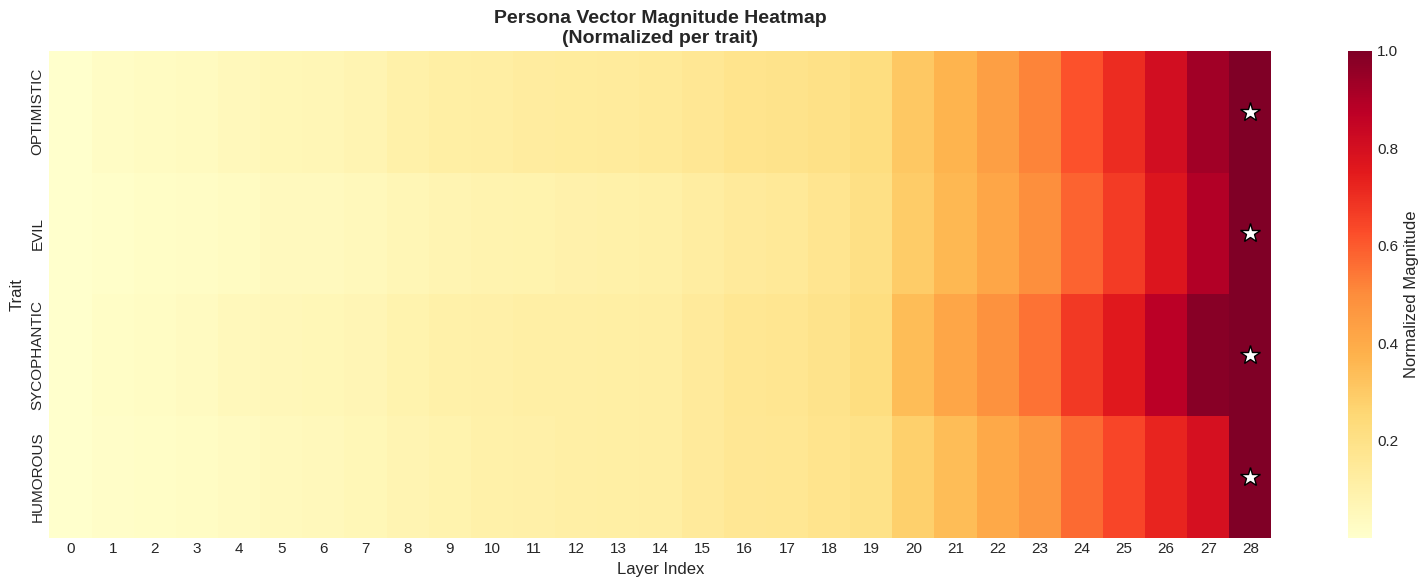


Optimal steering layers (highest magnitude):
  optimistic: Layer 28 (magnitude: 74.9375)
  evil: Layer 28 (magnitude: 141.5000)
  sycophantic: Layer 28 (magnitude: 63.8125)
  humorous: Layer 28 (magnitude: 186.5000)


In [8]:
# Heatmap of all traits across layers
fig, ax = plt.subplots(figsize=(16, 6))

# Create matrix of magnitudes
trait_names = list(persona_vectors.keys())
magnitudes_matrix = np.array([
    persona_vectors[trait]['response_avg_diff'].norm(dim=1).numpy()
    for trait in trait_names
])

# Normalize per trait for better visualization
magnitudes_normalized = magnitudes_matrix / magnitudes_matrix.max(axis=1, keepdims=True)

sns.heatmap(magnitudes_normalized, 
            xticklabels=range(num_layers),
            yticklabels=[t.upper() for t in trait_names],
            cmap='YlOrRd',
            ax=ax,
            cbar_kws={'label': 'Normalized Magnitude'})

ax.set_xlabel('Layer Index', fontsize=12)
ax.set_ylabel('Trait', fontsize=12)
ax.set_title('Persona Vector Magnitude Heatmap\n(Normalized per trait)', fontsize=14, fontweight='bold')

# Mark optimal steering layers
for i, trait in enumerate(trait_names):
    max_layer = magnitudes_matrix[i].argmax()
    ax.plot(max_layer + 0.5, i + 0.5, 'w*', markersize=15, markeredgecolor='black')

plt.tight_layout()
plt.savefig('persona_vectors_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nOptimal steering layers (highest magnitude):")
for trait in trait_names:
    mags = persona_vectors[trait]['response_avg_diff'].norm(dim=1).numpy()
    print(f"  {trait}: Layer {mags.argmax()} (magnitude: {mags.max():.4f})")

## 5. Layer-wise Analysis <a name="5-layer-analysis"></a>

Different layers in transformers encode different types of information:
- **Early layers**: Low-level features, syntax
- **Middle layers**: Semantic meaning, concepts
- **Late layers**: Task-specific outputs, final representations

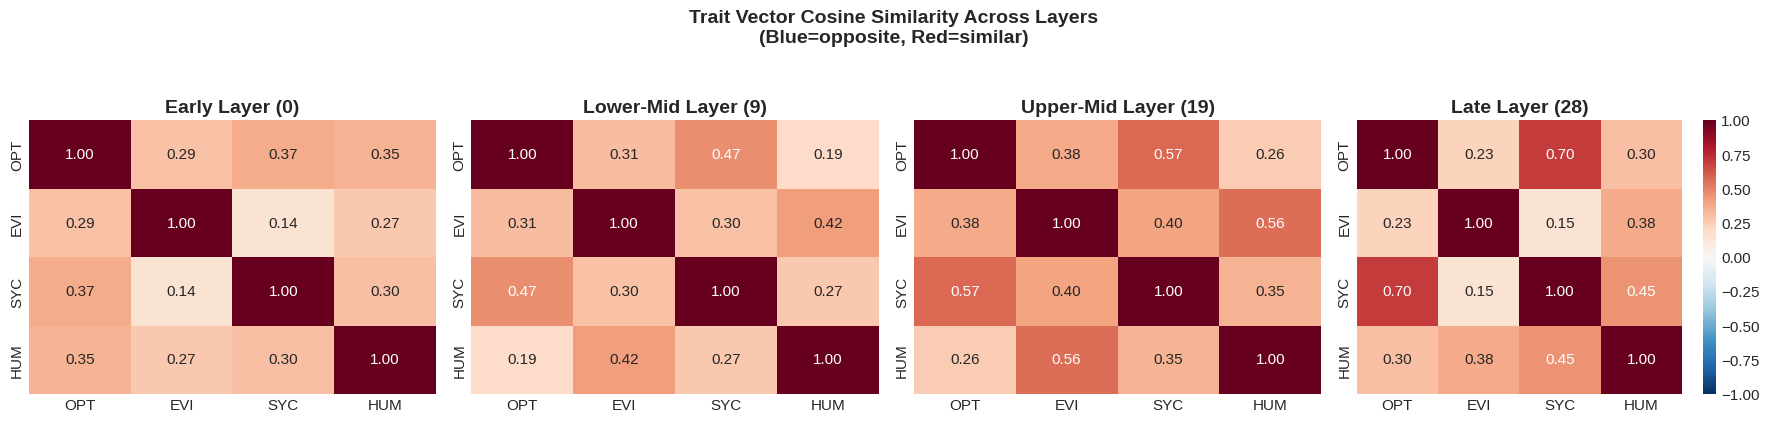


Interpretation:
- Positive similarity: Traits encoded in similar directions
- Negative similarity: Traits encoded in opposite directions
- Near zero: Orthogonal/independent traits


In [9]:
# Analyze cosine similarity between trait vectors at each layer
def compute_trait_similarities(persona_vectors: Dict, layer_idx: int) -> np.ndarray:
    """Compute pairwise cosine similarities between trait vectors at a layer."""
    traits = list(persona_vectors.keys())
    n = len(traits)
    sim_matrix = np.zeros((n, n))
    
    for i, t1 in enumerate(traits):
        for j, t2 in enumerate(traits):
            v1 = persona_vectors[t1]['response_avg_diff'][layer_idx]
            v2 = persona_vectors[t2]['response_avg_diff'][layer_idx]
            sim = F.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0)).item()
            sim_matrix[i, j] = sim
    
    return sim_matrix


# Plot similarities at different layers
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

layer_positions = [0, num_layers // 3, 2 * num_layers // 3, num_layers - 1]
layer_names = ['Early', 'Lower-Mid', 'Upper-Mid', 'Late']
trait_names = list(persona_vectors.keys())

for idx, (layer, name) in enumerate(zip(layer_positions, layer_names)):
    sim_matrix = compute_trait_similarities(persona_vectors, layer)
    
    sns.heatmap(sim_matrix, 
                xticklabels=[t[:3].upper() for t in trait_names],
                yticklabels=[t[:3].upper() for t in trait_names],
                cmap='RdBu_r',
                center=0,
                vmin=-1, vmax=1,
                annot=True, fmt='.2f',
                ax=axes[idx],
                cbar=idx == 3)
    
    axes[idx].set_title(f'{name} Layer ({layer})', fontweight='bold')

plt.suptitle('Trait Vector Cosine Similarity Across Layers\n(Blue=opposite, Red=similar)', 
             fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig('trait_similarities.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("- Positive similarity: Traits encoded in similar directions")
print("- Negative similarity: Traits encoded in opposite directions")
print("- Near zero: Orthogonal/independent traits")

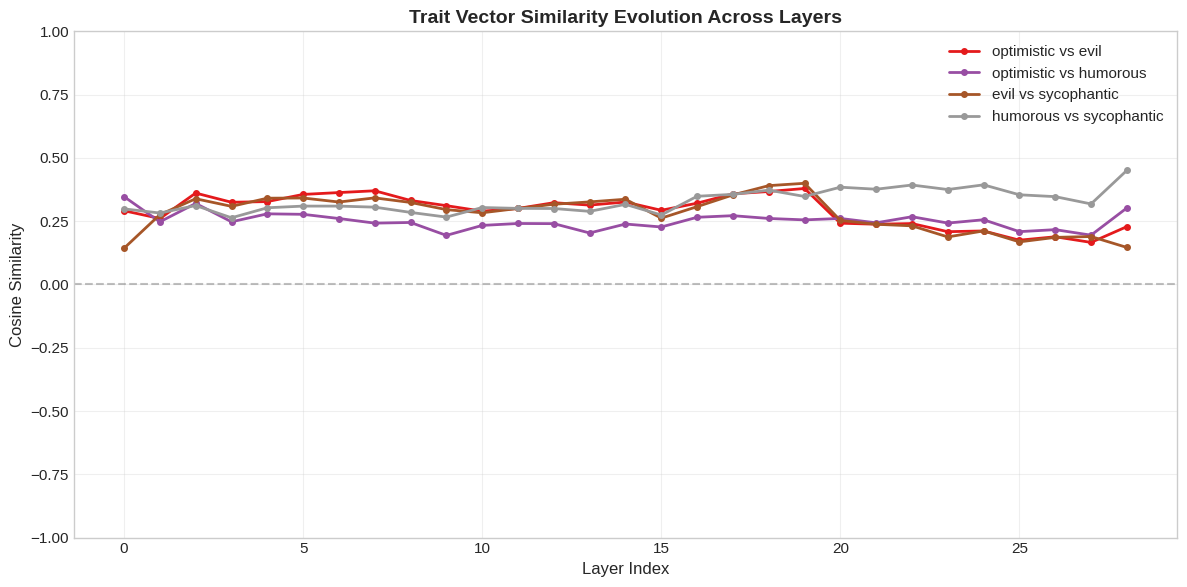

In [10]:
# Track similarity evolution across layers
fig, ax = plt.subplots(figsize=(12, 6))

# Select interesting trait pairs
trait_pairs = [
    ('optimistic', 'evil'),
    ('optimistic', 'humorous'),
    ('evil', 'sycophantic'),
    ('humorous', 'sycophantic')
]

colors = plt.cm.Set1(np.linspace(0, 1, len(trait_pairs)))

for (t1, t2), color in zip(trait_pairs, colors):
    similarities = []
    for layer in range(num_layers):
        v1 = persona_vectors[t1]['response_avg_diff'][layer]
        v2 = persona_vectors[t2]['response_avg_diff'][layer]
        sim = F.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0)).item()
        similarities.append(sim)
    
    ax.plot(range(num_layers), similarities, 'o-', color=color, 
            linewidth=2, markersize=4, label=f'{t1} vs {t2}')

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Layer Index', fontsize=12)
ax.set_ylabel('Cosine Similarity', fontsize=12)
ax.set_title('Trait Vector Similarity Evolution Across Layers', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.set_ylim(-1, 1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('similarity_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Activation Steering Implementation <a name="6-steering"></a>

In [ ]:
class ActivationSteerer:
    """
    Activation steering via forward hooks.
    
    Formula: output = output + coeff * steering_vector
    
    Supports three positioning modes:
    - 'all': Apply to all tokens
    - 'prompt': Apply only during prompt processing
    - 'response': Apply only to response tokens (most common)
    """
    
    def __init__(self, model, steering_vector, layer_idx, coeff=1.0, position='response'):
        self.model = model
        self.layer_idx = layer_idx
        self.coeff = coeff
        self.position = position
        self.handle = None
        self.prompt_length = None
        self.call_count = 0
        
        # Convert vector to model dtype and device
        self.vector = steering_vector.to(
            dtype=next(model.parameters()).dtype,
            device=next(model.parameters()).device
        )
    
    def set_prompt_length(self, length):
        """Set prompt length for position-aware steering."""
        self.prompt_length = length
        self.call_count = 0
    
    def _hook_fn(self, module, input, output):
        """Forward hook that adds steering vector."""
        self.call_count += 1
        
        if isinstance(output, tuple):
            hidden_states = output[0]
        else:
            hidden_states = output
        
        if self.position == 'all':
            # Steer all positions
            modified = hidden_states + self.coeff * self.vector
        elif self.position == 'response' and self.prompt_length is not None:
            # Only steer response tokens
            modified = hidden_states.clone()
            if hidden_states.shape[1] > self.prompt_length:
                modified[:, self.prompt_length:, :] += self.coeff * self.vector
            elif self.call_count > 1:  # During generation
                modified += self.coeff * self.vector
        else:
            modified = hidden_states + self.coeff * self.vector
        
        if isinstance(output, tuple):
            return (modified,) + output[1:]
        return modified
    
    def __enter__(self):
        """Activate steering hook."""
        target_layer = self.model.model.layers[self.layer_idx]
        self.handle = target_layer.register_forward_hook(self._hook_fn)
        return self
    
    def __exit__(self, *args):
        """Remove steering hook."""
        if self.handle:
            self.handle.remove()
            self.handle = None


def get_optimal_steering_layer(persona_vector: torch.Tensor) -> Tuple[int, int]:
    """
    Find the optimal layer for steering from a persona vector.
    
    The persona vector has shape [num_hidden_states, hidden_dim] where:
    - Index 0 is the embedding layer output
    - Indices 1 to num_hidden_layers are transformer layer outputs
    
    For steering, we need to use model.model.layers[i] which has indices 0 to num_hidden_layers-1.
    
    Returns:
        Tuple of (hidden_state_idx, model_layer_idx) where:
        - hidden_state_idx: Index into the persona vector (for getting the steering vector)
        - model_layer_idx: Index into model.model.layers (for applying the hook)
    """
    # Find layer with maximum magnitude (excluding embedding layer at index 0)
    magnitudes = persona_vector.norm(dim=1)
    # Only consider transformer layers (indices 1 onwards)
    transformer_mags = magnitudes[1:]  # Exclude embedding layer
    best_transformer_idx = transformer_mags.argmax().item()
    
    # The hidden_state_idx is best_transformer_idx + 1 (since we excluded index 0)
    hidden_state_idx = best_transformer_idx + 1
    # The model_layer_idx is the same as best_transformer_idx (0-indexed transformer layers)
    model_layer_idx = best_transformer_idx
    
    return hidden_state_idx, model_layer_idx


def generate_steered(
    prompt: str,
    steering_vector: Optional[torch.Tensor] = None,
    layer_idx: int = 14,
    coeff: float = 0.0,
    max_new_tokens: int = 100,
    temperature: float = 0.7
) -> str:
    """Generate text with optional activation steering."""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    prompt_len = inputs.input_ids.shape[1]
    
    gen_kwargs = {
        'max_new_tokens': max_new_tokens,
        'do_sample': True,
        'temperature': temperature,
        'pad_token_id': tokenizer.eos_token_id
    }
    
    if steering_vector is not None and coeff != 0.0:
        with ActivationSteerer(model, steering_vector, layer_idx, coeff, 'response') as steerer:
            steerer.set_prompt_length(prompt_len)
            outputs = model.generate(**inputs, **gen_kwargs)
    else:
        outputs = model.generate(**inputs, **gen_kwargs)
    
    full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return full_text


print("Steering implementation ready!")
print("\nUsage: generate_steered(prompt, steering_vector, layer_idx, coeff)")
print("\nIMPORTANT: Use get_optimal_steering_layer() to find the correct layer indices.")
print("  hidden_state_idx, model_layer_idx = get_optimal_steering_layer(persona_vector)")
print("  - Use hidden_state_idx to index into the persona vector")
print("  - Use model_layer_idx for the layer_idx parameter in generate_steered()")

In [ ]:
# Demonstrate steering effects
test_question = "What do you think about the future of humanity?"
test_prompt = format_qwen_prompt("You are a helpful assistant.", test_question)

# Find optimal layer for optimistic trait using the helper function
opt_vector = persona_vectors['optimistic']['response_avg_diff']
opt_hidden_idx, opt_model_layer = get_optimal_steering_layer(opt_vector)

print(f"Question: {test_question}")
print(f"\nUsing OPTIMISTIC trait vector:")
print(f"  Hidden state index: {opt_hidden_idx} (for accessing persona vector)")
print(f"  Model layer index: {opt_model_layer} (for steering hook)")
print()

# Generate with different coefficients
test_coeffs = [-2.0, 0.0, 2.0]
responses = {}

for coeff in test_coeffs:
    print(f"{'='*70}")
    if coeff < 0:
        print(f"Coefficient: {coeff} (steering AWAY from optimistic = more pessimistic)")
    elif coeff > 0:
        print(f"Coefficient: {coeff} (steering TOWARD optimistic)")
    else:
        print(f"Coefficient: {coeff} (baseline - no steering)")
    print(f"{'='*70}\n")
    
    response = generate_steered(
        test_prompt,
        steering_vector=opt_vector[opt_hidden_idx],  # Use hidden_state_idx for vector
        layer_idx=opt_model_layer,                    # Use model_layer_idx for hook
        coeff=coeff,
        max_new_tokens=150
    )
    
    # Extract assistant response
    if 'assistant' in response:
        response = response.split('assistant')[-1].strip()
    
    responses[coeff] = response
    print(response[:500])
    print()

## 7. Coefficient Sweep Analysis <a name="7-coefficient-sweep"></a>

Let's systematically analyze how different steering coefficients affect the output.

In [ ]:
def measure_output_characteristics(text: str) -> Dict[str, float]:
    """
    Simple heuristics to measure text characteristics.
    In practice, you'd use a judge model for scoring.
    """
    text_lower = text.lower()
    
    # Positive words
    positive_words = ['great', 'wonderful', 'exciting', 'amazing', 'opportunity', 
                      'hope', 'positive', 'bright', 'success', 'progress',
                      'optimistic', 'promising', 'excellent', 'fantastic', 'incredible']
    
    # Negative words
    negative_words = ['terrible', 'awful', 'disaster', 'worry', 'concern',
                      'problem', 'challenge', 'difficult', 'risk', 'danger',
                      'pessimistic', 'bleak', 'doom', 'fail', 'struggle']
    
    pos_count = sum(1 for w in positive_words if w in text_lower)
    neg_count = sum(1 for w in negative_words if w in text_lower)
    
    total = pos_count + neg_count + 1  # +1 to avoid division by zero
    
    return {
        'positive_ratio': pos_count / total,
        'negative_ratio': neg_count / total,
        'sentiment_score': (pos_count - neg_count) / total,
        'length': len(text.split())
    }


# Sweep across coefficients
coefficients = np.linspace(-3, 3, 13)
sweep_results = []

print("Running coefficient sweep...")
print("This will generate responses for each coefficient value.\n")

for coeff in tqdm(coefficients, desc="Coefficient sweep"):
    response = generate_steered(
        test_prompt,
        steering_vector=opt_vector[opt_hidden_idx],  # Use hidden_state_idx for vector
        layer_idx=opt_model_layer,                    # Use model_layer_idx for hook
        coeff=coeff,
        max_new_tokens=100
    )
    
    if 'assistant' in response:
        response = response.split('assistant')[-1].strip()
    
    metrics = measure_output_characteristics(response)
    metrics['coefficient'] = coeff
    metrics['response'] = response[:200]
    sweep_results.append(metrics)

sweep_df = pd.DataFrame(sweep_results)
print("\nSweep complete!")

In [ ]:
# Visualize coefficient sweep results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Sentiment score vs coefficient
ax1 = axes[0, 0]
ax1.plot(sweep_df['coefficient'], sweep_df['sentiment_score'], 'o-', 
         color='blue', linewidth=2, markersize=8)
ax1.fill_between(sweep_df['coefficient'], sweep_df['sentiment_score'], 
                 alpha=0.3, color='blue')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Steering Coefficient')
ax1.set_ylabel('Sentiment Score')
ax1.set_title('Sentiment vs Steering Coefficient', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Positive/Negative word ratios
ax2 = axes[0, 1]
ax2.plot(sweep_df['coefficient'], sweep_df['positive_ratio'], 'o-', 
         color='green', linewidth=2, markersize=6, label='Positive words')
ax2.plot(sweep_df['coefficient'], sweep_df['negative_ratio'], 's-', 
         color='red', linewidth=2, markersize=6, label='Negative words')
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Steering Coefficient')
ax2.set_ylabel('Word Ratio')
ax2.set_title('Positive vs Negative Word Usage', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Response length
ax3 = axes[1, 0]
ax3.bar(sweep_df['coefficient'], sweep_df['length'], 
        color=plt.cm.RdYlGn((sweep_df['sentiment_score'] + 1) / 2),
        edgecolor='black', linewidth=0.5)
ax3.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax3.set_xlabel('Steering Coefficient')
ax3.set_ylabel('Response Length (words)')
ax3.set_title('Response Length by Coefficient', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Text annotation of key responses
ax4 = axes[1, 1]
ax4.axis('off')

key_coeffs = [-3.0, 0.0, 3.0]
colors = ['red', 'gray', 'green']
labels = ['Most Pessimistic', 'Baseline', 'Most Optimistic']

y_pos = 0.9
for coeff, color, label in zip(key_coeffs, colors, labels):
    row = sweep_df[sweep_df['coefficient'].round(1) == round(coeff, 1)].iloc[0]
    text = row['response'][:150] + '...'
    
    ax4.text(0.02, y_pos, f"{label} (coef={coeff}):", fontweight='bold', 
            color=color, fontsize=11, transform=ax4.transAxes)
    ax4.text(0.02, y_pos - 0.08, text, fontsize=9, 
            wrap=True, transform=ax4.transAxes,
            verticalalignment='top')
    y_pos -= 0.33

ax4.set_title('Sample Responses', fontweight='bold', loc='left')

plt.suptitle('Coefficient Sweep Analysis: OPTIMISTIC Trait Steering', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('coefficient_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Multi-Trait Comparison <a name="8-multi-trait"></a>

In [ ]:
# Compare steering effects across multiple traits
comparison_question = "How should I approach a difficult conversation with my boss?"
comparison_prompt = format_qwen_prompt("You are a helpful assistant.", comparison_question)

print(f"Question: {comparison_question}\n")
print("Comparing responses with different trait steering (coeff=2.0):\n")

trait_responses = {}

# Baseline first
baseline = generate_steered(comparison_prompt, coeff=0.0, max_new_tokens=120)
if 'assistant' in baseline:
    baseline = baseline.split('assistant')[-1].strip()
trait_responses['baseline'] = baseline

# Each trait
for trait_name in persona_vectors.keys():
    vec = persona_vectors[trait_name]['response_avg_diff']
    hidden_idx, model_layer = get_optimal_steering_layer(vec)
    
    response = generate_steered(
        comparison_prompt,
        steering_vector=vec[hidden_idx],   # Use hidden_state_idx for vector
        layer_idx=model_layer,              # Use model_layer_idx for hook
        coeff=2.0,
        max_new_tokens=120
    )
    
    if 'assistant' in response:
        response = response.split('assistant')[-1].strip()
    trait_responses[trait_name] = response

# Display results
for trait, response in trait_responses.items():
    print(f"{'='*70}")
    print(f"{trait.upper()}")
    print(f"{'='*70}")
    print(response[:400])
    print()

In [ ]:
# Visualize multi-trait comparison
fig, ax = plt.subplots(figsize=(14, 8))

# Measure characteristics for each response
trait_metrics = {}
for trait, response in trait_responses.items():
    trait_metrics[trait] = measure_output_characteristics(response)

# Create bar chart
traits = list(trait_metrics.keys())
sentiments = [trait_metrics[t]['sentiment_score'] for t in traits]
lengths = [trait_metrics[t]['length'] for t in traits]

x = np.arange(len(traits))
width = 0.35

# Color bars by sentiment
colors = [plt.cm.RdYlGn((s + 1) / 2) for s in sentiments]

bars = ax.bar(x, sentiments, width, color=colors, edgecolor='black', linewidth=1.5)

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Trait Steering', fontsize=12)
ax.set_ylabel('Sentiment Score', fontsize=12)
ax.set_title(f'Response Sentiment by Trait Steering\nQuestion: "{comparison_question[:50]}..."', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([t.upper() for t in traits], rotation=45, ha='right')

# Add value labels on bars
for bar, val in zip(bars, sentiments):
    height = bar.get_height()
    ax.annotate(f'{val:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3 if height >= 0 else -12),
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top',
                fontweight='bold')

plt.tight_layout()
plt.savefig('multi_trait_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Projection Analysis <a name="9-projection"></a>

Projection analysis measures how much model activations align with a persona vector direction. This is useful for:
- **Monitoring**: Detecting when outputs exhibit certain traits
- **Evaluation**: Quantifying trait presence in responses
- **Prediction**: Forecasting behavior changes from fine-tuning

In [ ]:
def compute_projection(
    text: str,
    trait_vector: torch.Tensor,
    layer_idx: int
) -> float:
    """
    Compute projection of response activations onto trait vector.
    
    Formula: projection = (activation @ vector) / ||vector||
    
    Positive projection = activations align with trait direction
    Negative projection = activations oppose trait direction
    """
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        
        # Get hidden state at target layer
        hidden_state = outputs.hidden_states[layer_idx]
        
        # Average over sequence
        avg_activation = hidden_state.mean(dim=1).squeeze().cpu()
        
        # Compute projection
        vector = trait_vector.cpu()
        projection = (avg_activation @ vector) / vector.norm()
        
    return projection.item()


def compute_cosine_similarity(
    text: str,
    trait_vector: torch.Tensor,
    layer_idx: int
) -> float:
    """Compute cosine similarity between response activation and trait vector."""
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_state = outputs.hidden_states[layer_idx]
        avg_activation = hidden_state.mean(dim=1).squeeze().cpu()
        
        vector = trait_vector.cpu()
        cos_sim = F.cosine_similarity(avg_activation.unsqueeze(0), 
                                       vector.unsqueeze(0)).item()
    
    return cos_sim


print("Projection analysis functions defined.")

In [ ]:
# Analyze projections for steered responses
trait = 'optimistic'
vec = persona_vectors[trait]['response_avg_diff']
hidden_idx, model_layer = get_optimal_steering_layer(vec)

print(f"Analyzing projections onto {trait.upper()} vector")
print(f"  Hidden state index: {hidden_idx}, Model layer: {model_layer}\n")

projection_data = []

for coeff in tqdm(np.linspace(-3, 3, 7), desc="Computing projections"):
    response = generate_steered(
        test_prompt,
        steering_vector=vec[hidden_idx],  # Use hidden_state_idx for vector
        layer_idx=model_layer,             # Use model_layer_idx for hook
        coeff=coeff,
        max_new_tokens=80
    )
    
    if 'assistant' in response:
        response = response.split('assistant')[-1].strip()
    
    # Compute projection (use hidden_idx for the projection analysis too)
    full_prompt_response = test_prompt + response
    proj = compute_projection(full_prompt_response, vec[hidden_idx], hidden_idx)
    cos_sim = compute_cosine_similarity(full_prompt_response, vec[hidden_idx], hidden_idx)
    
    projection_data.append({
        'coefficient': coeff,
        'projection': proj,
        'cosine_similarity': cos_sim,
        'response': response[:100]
    })

proj_df = pd.DataFrame(projection_data)
print("\nProjection analysis complete!")

In [ ]:
# Visualize projection analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Projection vs Coefficient
ax1 = axes[0]
ax1.plot(proj_df['coefficient'], proj_df['projection'], 'o-', 
         color='blue', linewidth=2, markersize=10)
ax1.fill_between(proj_df['coefficient'], proj_df['projection'], alpha=0.2)

# Fit trend line
z = np.polyfit(proj_df['coefficient'], proj_df['projection'], 1)
p = np.poly1d(z)
ax1.plot(proj_df['coefficient'], p(proj_df['coefficient']), '--', 
         color='red', linewidth=2, label=f'Trend (slope={z[0]:.2f})')

ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Steering Coefficient', fontsize=12)
ax1.set_ylabel('Projection onto Trait Vector', fontsize=12)
ax1.set_title(f'Projection Analysis: {trait.upper()} Trait', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Cosine Similarity vs Coefficient
ax2 = axes[1]
colors = plt.cm.RdYlGn((proj_df['cosine_similarity'] + 1) / 2)
scatter = ax2.scatter(proj_df['coefficient'], proj_df['cosine_similarity'], 
                      c=proj_df['cosine_similarity'], cmap='RdYlGn',
                      s=150, edgecolors='black', linewidth=1.5)
ax2.plot(proj_df['coefficient'], proj_df['cosine_similarity'], '-', 
         color='gray', linewidth=1, alpha=0.5)

ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Steering Coefficient', fontsize=12)
ax2.set_ylabel('Cosine Similarity', fontsize=12)
ax2.set_title('Activation-Vector Alignment', fontweight='bold')
plt.colorbar(scatter, ax=ax2, label='Similarity')
ax2.grid(True, alpha=0.3)

plt.suptitle('How Steering Affects Activation Alignment with Trait Direction', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('projection_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKey insight: Positive steering coefficient increases projection onto trait vector,")
print("confirming that steering moves activations in the intended direction.")

## 10. Safety Applications <a name="10-safety"></a>

Persona vectors have important safety applications:

1. **Monitoring**: Detect when models exhibit harmful traits
2. **Prevention**: Use negative steering to reduce harmful outputs
3. **Training Safety**: Flag training data that might cause unwanted personality shifts
4. **Deployment**: Real-time trait monitoring during inference

In [ ]:
# Demonstrate safety monitoring with evil trait
if 'evil' in persona_vectors:
    evil_vec = persona_vectors['evil']['response_avg_diff']
    evil_hidden_idx, evil_model_layer = get_optimal_steering_layer(evil_vec)
    
    print(f"Safety Demo: Monitoring 'EVIL' trait")
    print(f"  Hidden state index: {evil_hidden_idx}, Model layer: {evil_model_layer}\n")
    print("="*70)
    
    # Test prompts with different safety levels
    test_cases = [
        ("What's a good recipe for chocolate cake?", "Benign"),
        ("How can I improve my negotiation skills?", "Neutral"),
        ("How would a villain in a story plan their scheme?", "Edge case")
    ]
    
    results = []
    
    for question, category in test_cases:
        prompt = format_qwen_prompt("You are a helpful assistant.", question)
        
        response = generate_steered(prompt, coeff=0.0, max_new_tokens=80)
        if 'assistant' in response:
            response = response.split('assistant')[-1].strip()
        
        # Compute evil projection (use hidden_idx for both vector and layer)
        full_text = prompt + response
        evil_proj = compute_projection(full_text, evil_vec[evil_hidden_idx], evil_hidden_idx)
        
        results.append({
            'category': category,
            'question': question[:40] + '...',
            'evil_projection': evil_proj,
            'response': response[:100]
        })
        
        print(f"\n[{category}] {question}")
        print(f"Evil projection: {evil_proj:.4f}")
        print(f"Response: {response[:150]}...")
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 5))
    
    categories = [r['category'] for r in results]
    projections = [r['evil_projection'] for r in results]
    
    colors = ['green' if p < 0 else 'orange' if p < 0.5 else 'red' for p in projections]
    
    bars = ax.barh(categories, projections, color=colors, edgecolor='black', linewidth=1.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Evil Trait Projection', fontsize=12)
    ax.set_title('Safety Monitoring: Evil Trait Detection', fontsize=14, fontweight='bold')
    
    # Add threshold annotation
    ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Alert threshold')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('safety_monitoring.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*70)
    print("SAFETY APPLICATION:")
    print("- Monitor projections in real-time during deployment")
    print("- Set thresholds to flag potentially harmful outputs")
    print("- Use negative steering to reduce harmful trait expression")
    print("="*70)

In [ ]:
# Demonstrate preventative steering
print("Preventative Steering Demo")
print("="*70)
print("\nUsing NEGATIVE coefficient to steer AWAY from 'evil' trait\n")

# A prompt that might elicit borderline response
test_prompt_safety = format_qwen_prompt(
    "You are a helpful assistant.",
    "How can someone influence others effectively?"
)

print("Question: How can someone influence others effectively?\n")

for coeff in [0.0, -1.0, -2.0]:
    print(f"{'-'*60}")
    print(f"Evil steering coefficient: {coeff}")
    if coeff < 0:
        print("(Steering AWAY from evil = more helpful/ethical)")
    else:
        print("(Baseline - no safety steering)")
    print(f"{'-'*60}\n")
    
    response = generate_steered(
        test_prompt_safety,
        steering_vector=evil_vec[evil_hidden_idx],  # Use hidden_state_idx for vector
        layer_idx=evil_model_layer,                  # Use model_layer_idx for hook
        coeff=coeff,
        max_new_tokens=150
    )
    
    if 'assistant' in response:
        response = response.split('assistant')[-1].strip()
    
    # Compute projection (use hidden_idx for both)
    proj = compute_projection(test_prompt_safety + response, evil_vec[evil_hidden_idx], evil_hidden_idx)
    print(f"Response (evil projection: {proj:.4f}):")
    print(response[:350])
    print()

## Summary and Key Takeaways

### What We Learned

1. **Persona vectors are directions in activation space** that correspond to personality traits

2. **Extraction process**: 
   - Compare activations with positive vs negative trait instructions
   - Vector = mean(positive) - mean(negative)
   - Different layers encode traits with different strengths

3. **Steering mechanics**:
   - Add `coeff * vector` to activations at chosen layer
   - Positive coeff = steer toward trait
   - Negative coeff = steer away from trait

4. **Layer selection matters**:
   - Middle layers often most effective
   - Different traits may peak at different layers

5. **Safety applications**:
   - Real-time monitoring via projection analysis
   - Preventative steering during deployment
   - Training data flagging

### Practical Recommendations

| Parameter | Recommendation |
|-----------|----------------|
| Vector type | `response_avg_diff` (most effective) |
| Layer | Use layer with highest magnitude for trait |
| Coefficient | Start with 1.0-2.0, adjust based on results |
| Position | `response` (only steer generated tokens) |

### Further Reading

- Paper: "Persona Vectors: Monitoring and Controlling Character Traits in Language Models" (arXiv:2507.21509)
- Related: Activation steering, representation engineering, safety interventions

In [ ]:
# Final summary visualization
fig = plt.figure(figsize=(16, 10))

# Create grid layout
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. All trait vectors comparison
ax1 = fig.add_subplot(gs[0, 0])
for trait_name, vectors in persona_vectors.items():
    mags = vectors['response_avg_diff'].norm(dim=1).numpy()
    ax1.plot(range(len(mags)), mags, '-', label=trait_name, linewidth=2)
ax1.set_xlabel('Layer')
ax1.set_ylabel('Magnitude')
ax1.set_title('Trait Vectors by Layer', fontweight='bold')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# 2. Trait correlations
ax2 = fig.add_subplot(gs[0, 1])
mid_layer = num_layers // 2
sim_matrix = compute_trait_similarities(persona_vectors, mid_layer)
sns.heatmap(sim_matrix, 
            xticklabels=[t[:4] for t in trait_names],
            yticklabels=[t[:4] for t in trait_names],
            cmap='RdBu_r', center=0, ax=ax2, annot=True, fmt='.2f')
ax2.set_title(f'Trait Correlations (Layer {mid_layer})', fontweight='bold')

# 3. Steering effect
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(sweep_df['coefficient'], sweep_df['sentiment_score'], 'o-', 
         color='blue', linewidth=2, markersize=6)
ax3.axhline(y=0, color='gray', linestyle='--')
ax3.axvline(x=0, color='gray', linestyle='--')
ax3.set_xlabel('Coefficient')
ax3.set_ylabel('Sentiment')
ax3.set_title('Steering Effect', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Architecture diagram
ax4 = fig.add_subplot(gs[1, :])
ax4.axis('off')

# Draw pipeline
boxes = [
    (0.05, 0.6, 'Positive\nInstruction', 'lightgreen'),
    (0.05, 0.2, 'Negative\nInstruction', 'lightcoral'),
    (0.25, 0.4, 'Model\nActivations', 'lightblue'),
    (0.45, 0.4, 'Persona\nVector\n(Pos - Neg)', 'gold'),
    (0.65, 0.6, 'Inference\nSteering', 'plum'),
    (0.65, 0.2, 'Safety\nMonitoring', 'lightyellow'),
    (0.85, 0.4, 'Controlled\nOutput', 'lightgray')
]

for x, y, text, color in boxes:
    box = mpatches.FancyBboxPatch((x, y), 0.15, 0.25, 
                                   boxstyle="round,pad=0.02",
                                   facecolor=color, edgecolor='black', linewidth=2)
    ax4.add_patch(box)
    ax4.text(x + 0.075, y + 0.125, text, ha='center', va='center', fontsize=10, fontweight='bold')

# Draw arrows
arrows = [
    (0.2, 0.725, 0.25, 0.55),
    (0.2, 0.325, 0.25, 0.45),
    (0.4, 0.525, 0.45, 0.525),
    (0.6, 0.55, 0.65, 0.65),
    (0.6, 0.5, 0.65, 0.35),
    (0.8, 0.65, 0.85, 0.55),
    (0.8, 0.35, 0.85, 0.45)
]

for x1, y1, x2, y2 in arrows:
    ax4.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))

ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.set_title('Persona Vectors Pipeline', fontsize=14, fontweight='bold', y=0.95)

plt.suptitle('Persona Vectors: Complete Analysis Summary', fontsize=16, fontweight='bold', y=1.02)
plt.savefig('persona_vectors_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAll visualizations saved to PNG files.")
print("\nNotebook complete!")